In [1]:
"""In this notebook, I apply an MI-based active learning algorithm to the PSAAP combustor.

Each successive batch writes out separate (x,z) coord files for each fidelity. I then use scripts from my htr-run-database
repository to run the corresponding simulation batches.

Initialisation:
- 03_2M.npz batch of LF runs (241 latin hypercube samples)
- 01_15M.npz batch of HF runs (38 latin hypercube samples)

Budget:
- 5 rounds of 100 per round (HF has cost 1, LF has cost 0.1)
"""

'In this notebook, I apply an MI-based active learning algorithm to the PSAAP combustor.\n\nEach successive batch writes out separate (x,z) coord files for each fidelity. I then use scripts from my htr-run-database\nrepository to run the corresponding simulation batches.\n\nInitialisation:\n- 03_2M.npz batch of LF runs (241 latin hypercube samples)\n- 01_15M.npz batch of HF runs (38 latin hypercube samples)\n\nBudget:\n- 5 rounds of 100 per round (HF has cost 1, LF has cost 0.1)\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.models.bfgpc import BFGPC_ELBO
from src.utils_plotting import plot_bfgpc_predictions_two_axes


In [3]:
lf_filepaths = ['03_2M.npz']
hf_filepaths = ['01_15M.npz']

def load_lf_data(filepaths):
    all_xs = []
    all_ys = []
    for filepath in filepaths:
        data = np.load("./../data/" + filepath)
        x = data["xis"][:, [2, 4]].astype(np.float32)
        y = data["chis"]
        all_xs.append(x)
        all_ys.append(y)

    xs = np.concatenate(all_xs, axis=0)
    ys = np.concatenate(all_ys, axis=0)

    return xs / np.array([[15, 100]]), ys

X_lf, Y_lf = load_lf_data(lf_filepaths)

def load_hf_data(filepaths):
    all_xs = []
    all_ys = []
    for filepath in filepaths:
        data = np.load("./../data/" + filepath)
        x = data["xis"][:, [2, 4]].astype(np.float32)
        y = data["chis"]
        all_xs.append(x)
        all_ys.append(y)

    xs = np.concatenate(all_xs, axis=0)
    ys = np.concatenate(all_ys, axis=0)

    return xs / np.array([[15, 100]]), ys

X_hf, Y_hf = load_hf_data(hf_filepaths)

print(len(Y_lf))
print(len(Y_hf))

X_lf = torch.from_numpy(X_lf).float()
X_hf = torch.from_numpy(X_hf).float()
Y_lf = torch.from_numpy(Y_lf).float()
Y_hf = torch.from_numpy(Y_hf).float()


241
38


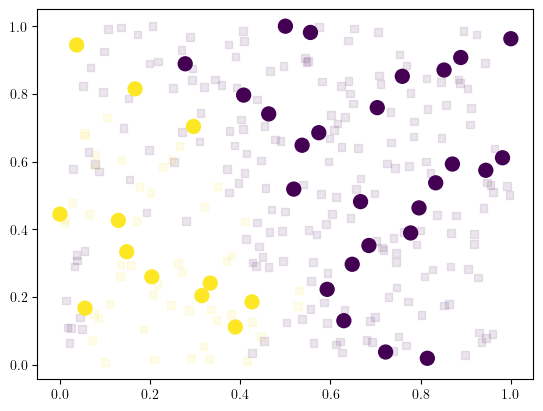

In [6]:
# Plot initial training data
plt.figure()
plt.scatter(X_lf[:, 0], X_lf[:, 1], c=Y_lf, cmap='viridis', marker='s', s=30, alpha=0.1)
plt.scatter(X_hf[:, 0], X_hf[:, 1], c=Y_hf, cmap='viridis', marker='o', s=100)
plt.show()


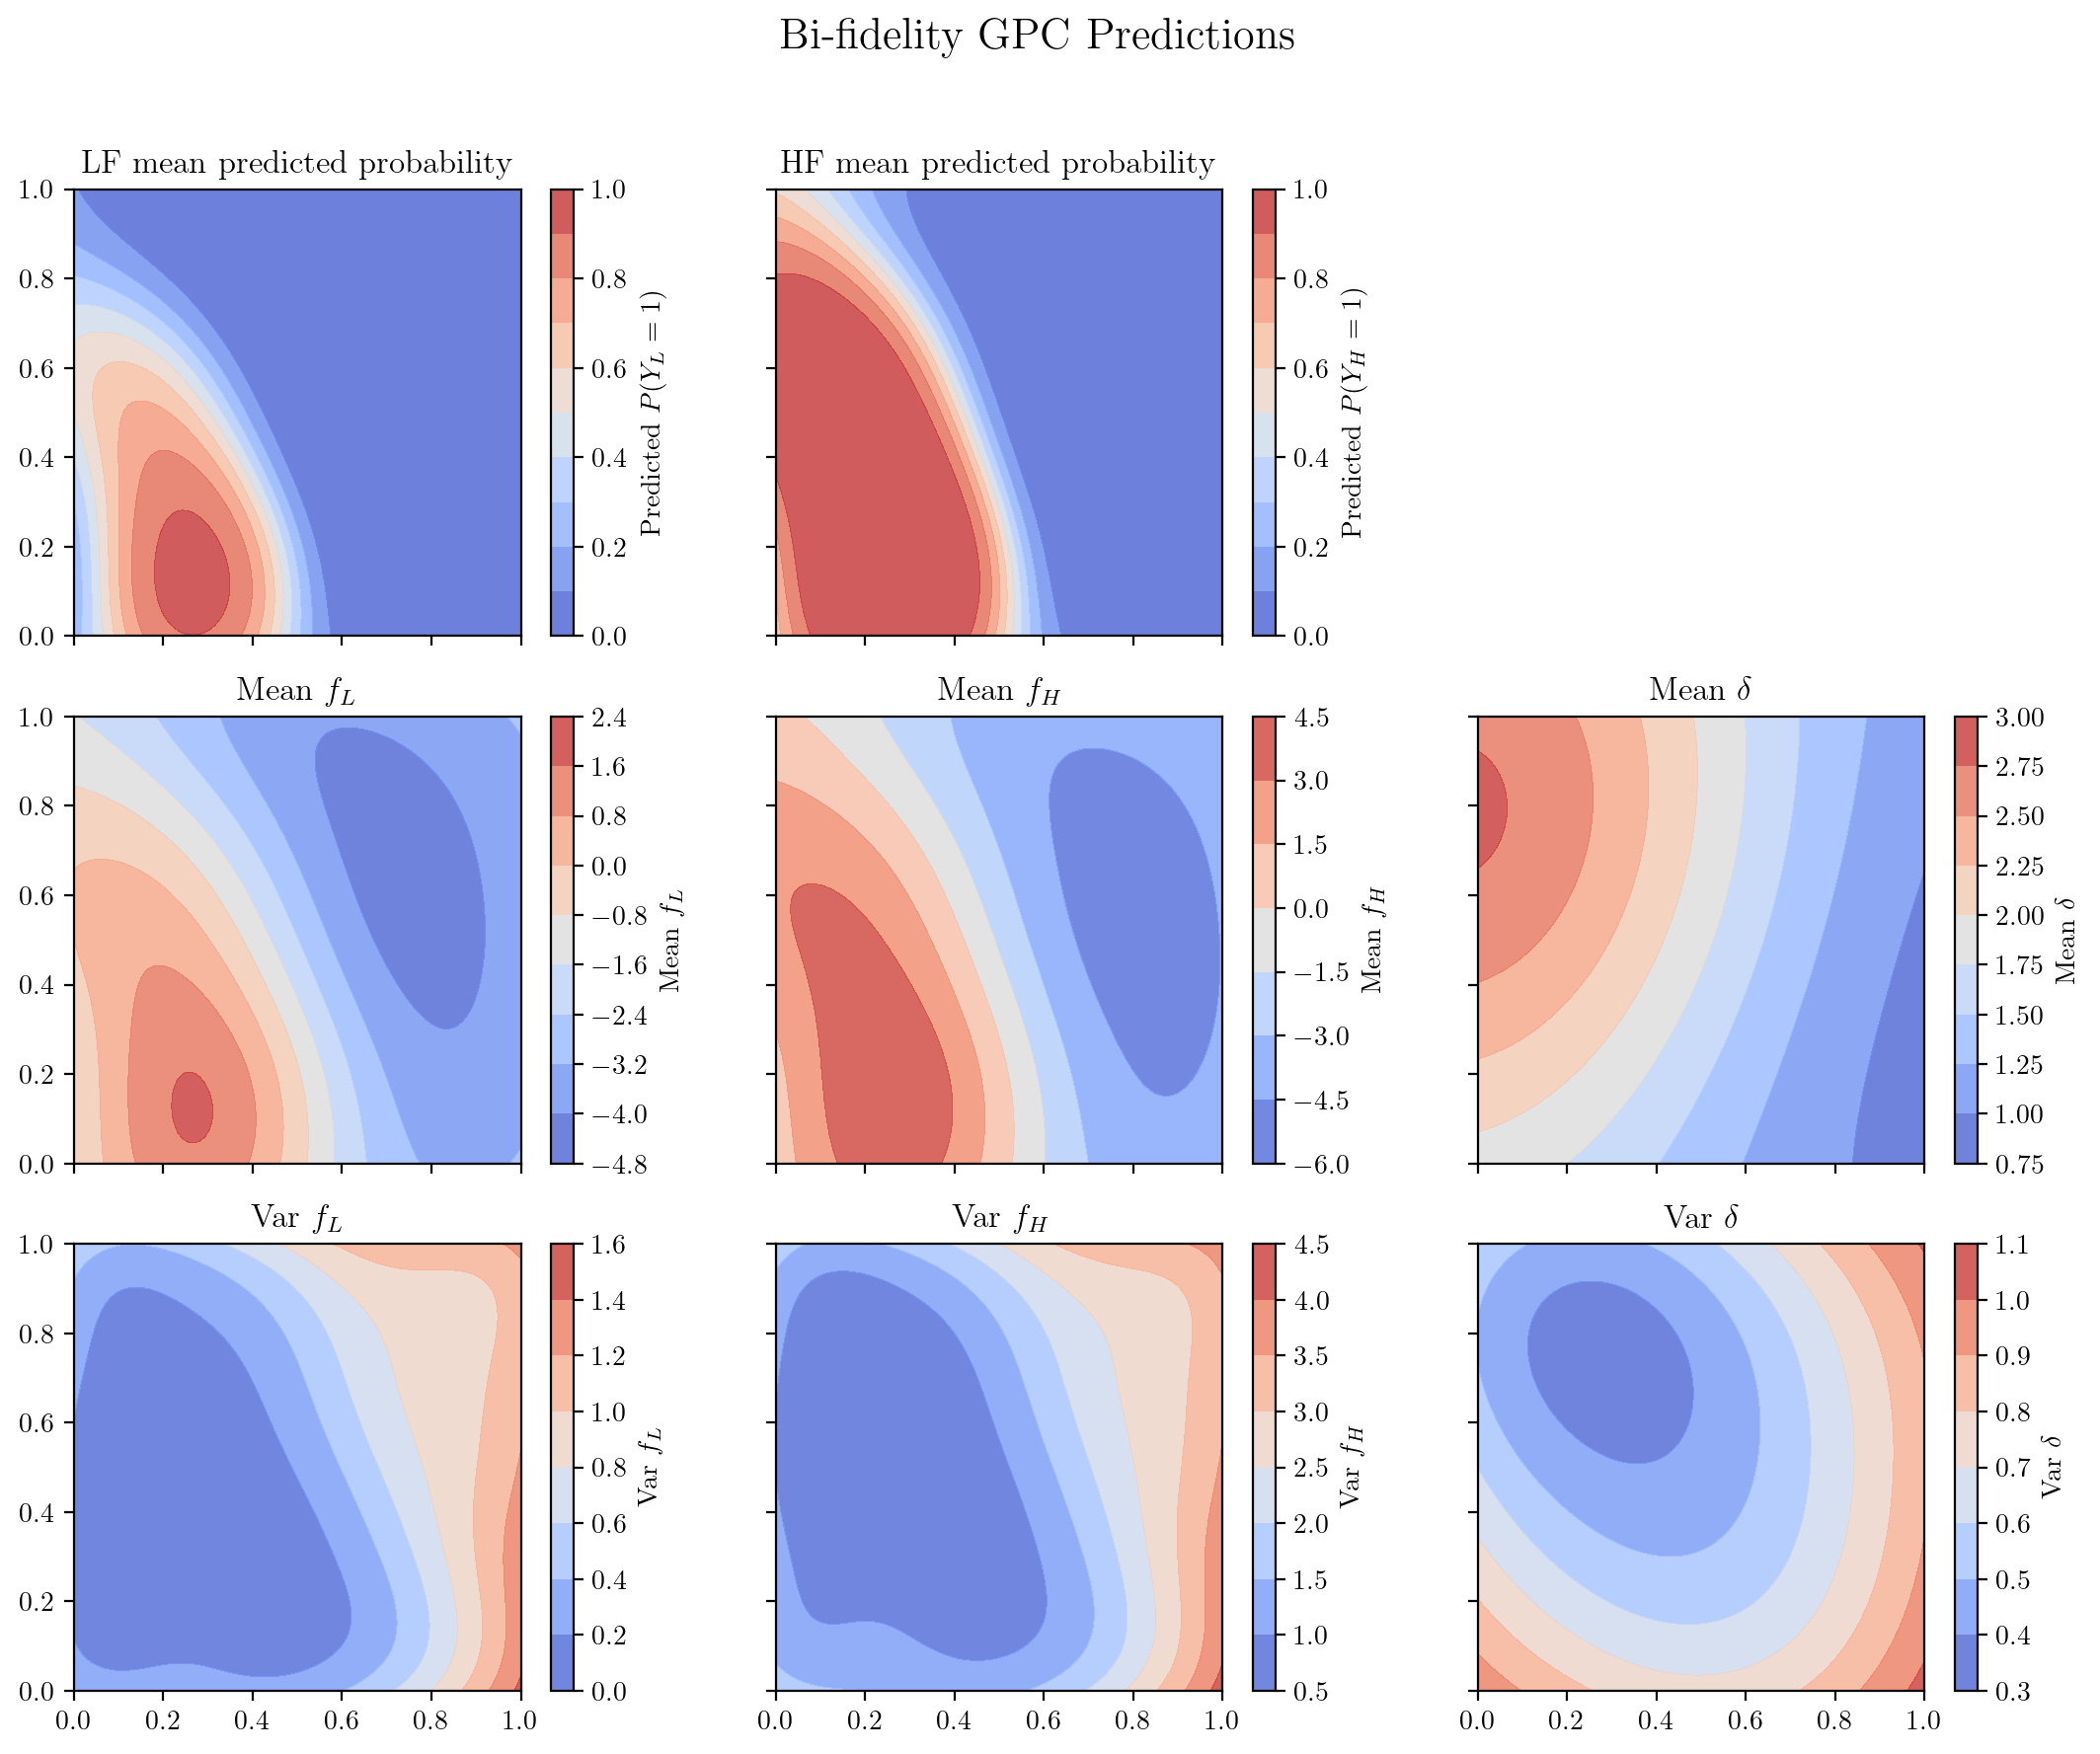

In [14]:
# Train initial model

model_0 = BFGPC_ELBO(X_lf, X_hf, n_inducing_pts=256)
model_0.train_model(X_lf, Y_lf, X_hf, Y_hf, n_epochs=100, lr=0.1, verbose=True)
plot_bfgpc_predictions_two_axes(model_0)


# Active Learning setup

In [8]:
from src.active_learning.util_classes import ALExperimentConfig, BiFidelityDataset
from src.batch_al_strategies.mutual_information_strategy_bernoulli_p_with_repeats import MutualInformationBernoulliPRepeatsStrategy

In [9]:
config = ALExperimentConfig(
    N_L_init=-1,
    N_H_init=-1,
    cost_constraints=[],
    N_cand_HF=2000,
    N_cand_LF=2000,
    train_lr=None,
    train_epochs=None,
    random_seed=0,
    N_reps=-1,
    model_args={"n_inducing_pts": 256},
)

psaap_dataset = BiFidelityDataset(
    sample_LF=None,
    sample_HF=None,
    true_p_LF=None,
    true_p_HF=None,
    name="PSAAP",
    c_LF=0.1,
    c_HF=1.0,
)

strategy = MutualInformationBernoulliPRepeatsStrategy(
    dataset=psaap_dataset,
    N_test_points=100,
    max_pool_subset=100,
    repeat_jitter=0.01,
    Nmax=5,
)

# Round 1

In [31]:
X_lf_new, X_hf_new = strategy.select_batch(config, model_0, budget_this_step=100)


Selecting batch:   0%|          | 0/100 [00:00<?, ?it/s]
Selecting batch:   0%|          | 0.1/100 [00:00<09:06,  5.47s/it]
Selecting batch:   0%|          | 0.2/100 [00:01<09:42,  5.84s/it]
Selecting batch:   0%|          | 0.30000000000000004/100 [00:01<09:44,  5.86s/it]
Selecting batch:   0%|          | 0.4/100 [00:02<09:46,  5.89s/it]                
Selecting batch:   0%|          | 0.5/100 [00:02<09:37,  5.80s/it]
Selecting batch:   1%|          | 0.6/100 [00:03<09:25,  5.68s/it]
Selecting batch:   1%|          | 0.7/100 [00:03<09:15,  5.59s/it]
Selecting batch:   1%|          | 0.7999999999999999/100 [00:04<09:10,  5.55s/it]
Selecting batch:   1%|          | 1.1/100 [00:04<07:27,  4.53s/it]               
Selecting batch:   2%|▏         | 1.5/100 [00:05<06:01,  3.67s/it]
Selecting batch:   2%|▏         | 1.9/100 [00:06<05:23,  3.30s/it]
Selecting batch:   2%|▏         | 2.1/100 [00:06<05:21,  3.29s/it]
Selecting batch:   2%|▏         | 2.2/100 [00:07<05:30,  3.38s/it]
Selecting

In [32]:
print(len(X_lf_new), len(X_hf_new))

240 76


In [34]:
# Rescale coordinates
X_lf_new *= np.array([[15, 100]])
X_hf_new *= np.array([[15, 100]])

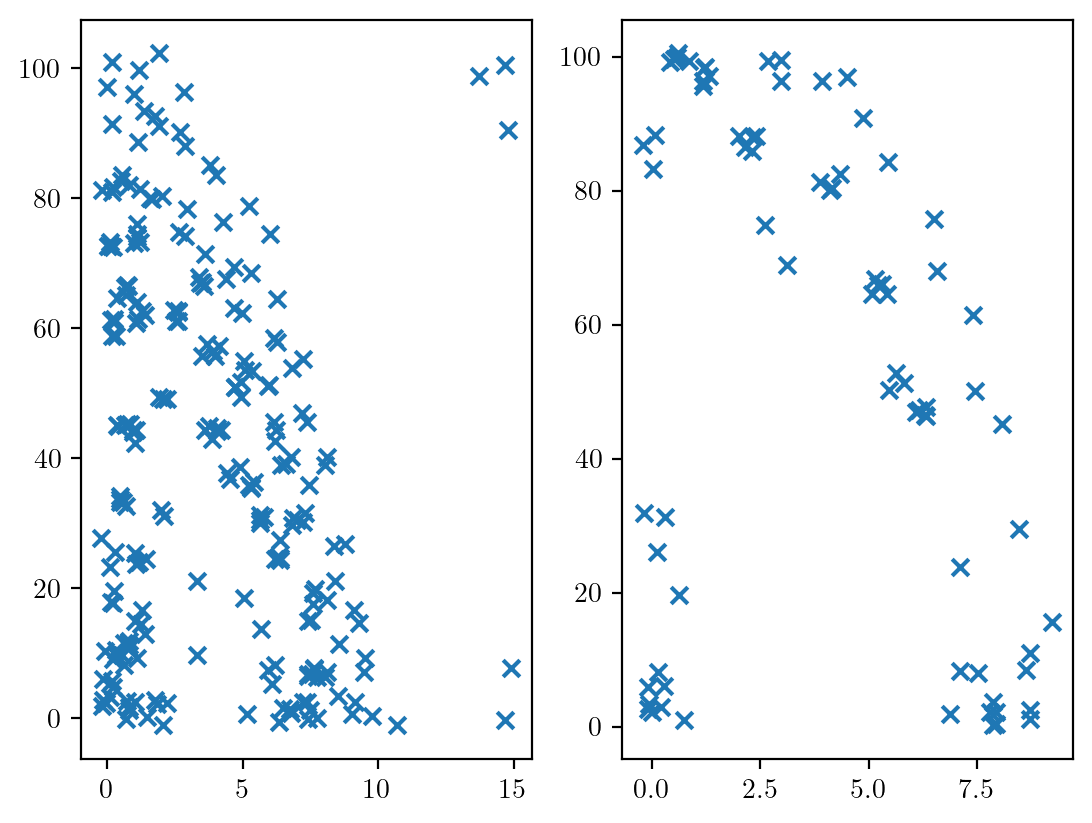

In [35]:
# Plot new training points

fig, axs = plt.subplots(1, 2, dpi=200)
axs[0].scatter(X_lf_new[:, 0], X_lf_new[:, 1], marker='x')
axs[1].scatter(X_hf_new[:, 0], X_hf_new[:, 1], marker='x')
plt.show()

In [36]:
# TODO: save model_0 to file, save X_lf_new and X_hf_new to separate files

# Save the model's state dictionary
torch.save(model_0.state_dict(), 'model_0.pt')

np.save('X_lf_new_1.npy', X_lf_new)
np.save('X_hf_new_1.npy', X_hf_new)



# Round 2


469
81


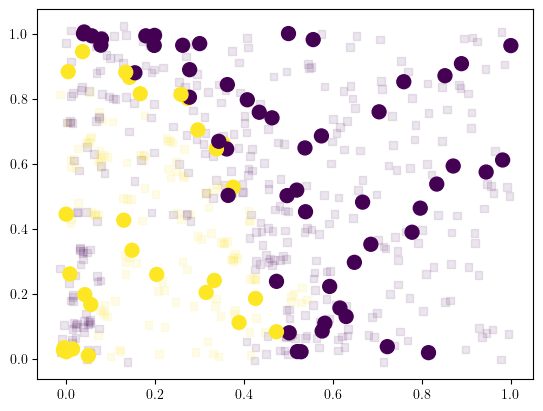

In [7]:
# Update training data

lf_filepaths = ['03_2M.npz', 'AL_01_2M.npz']
hf_filepaths = ['01_15M.npz', 'AL_01_15M.npz']

X_lf, Y_lf = load_lf_data(lf_filepaths)
X_hf, Y_hf = load_hf_data(hf_filepaths)

print(len(Y_lf))
print(len(Y_hf))

X_lf = torch.from_numpy(X_lf).float()
X_hf = torch.from_numpy(X_hf).float()
Y_lf = torch.from_numpy(Y_lf).float()
Y_hf = torch.from_numpy(Y_hf).float()

# Plot training data
plt.figure()
plt.scatter(X_lf[:, 0], X_lf[:, 1], c=Y_lf, cmap='viridis', marker='s', s=30, alpha=0.1)
plt.scatter(X_hf[:, 0], X_hf[:, 1], c=Y_hf, cmap='viridis', marker='o', s=100)
plt.show()


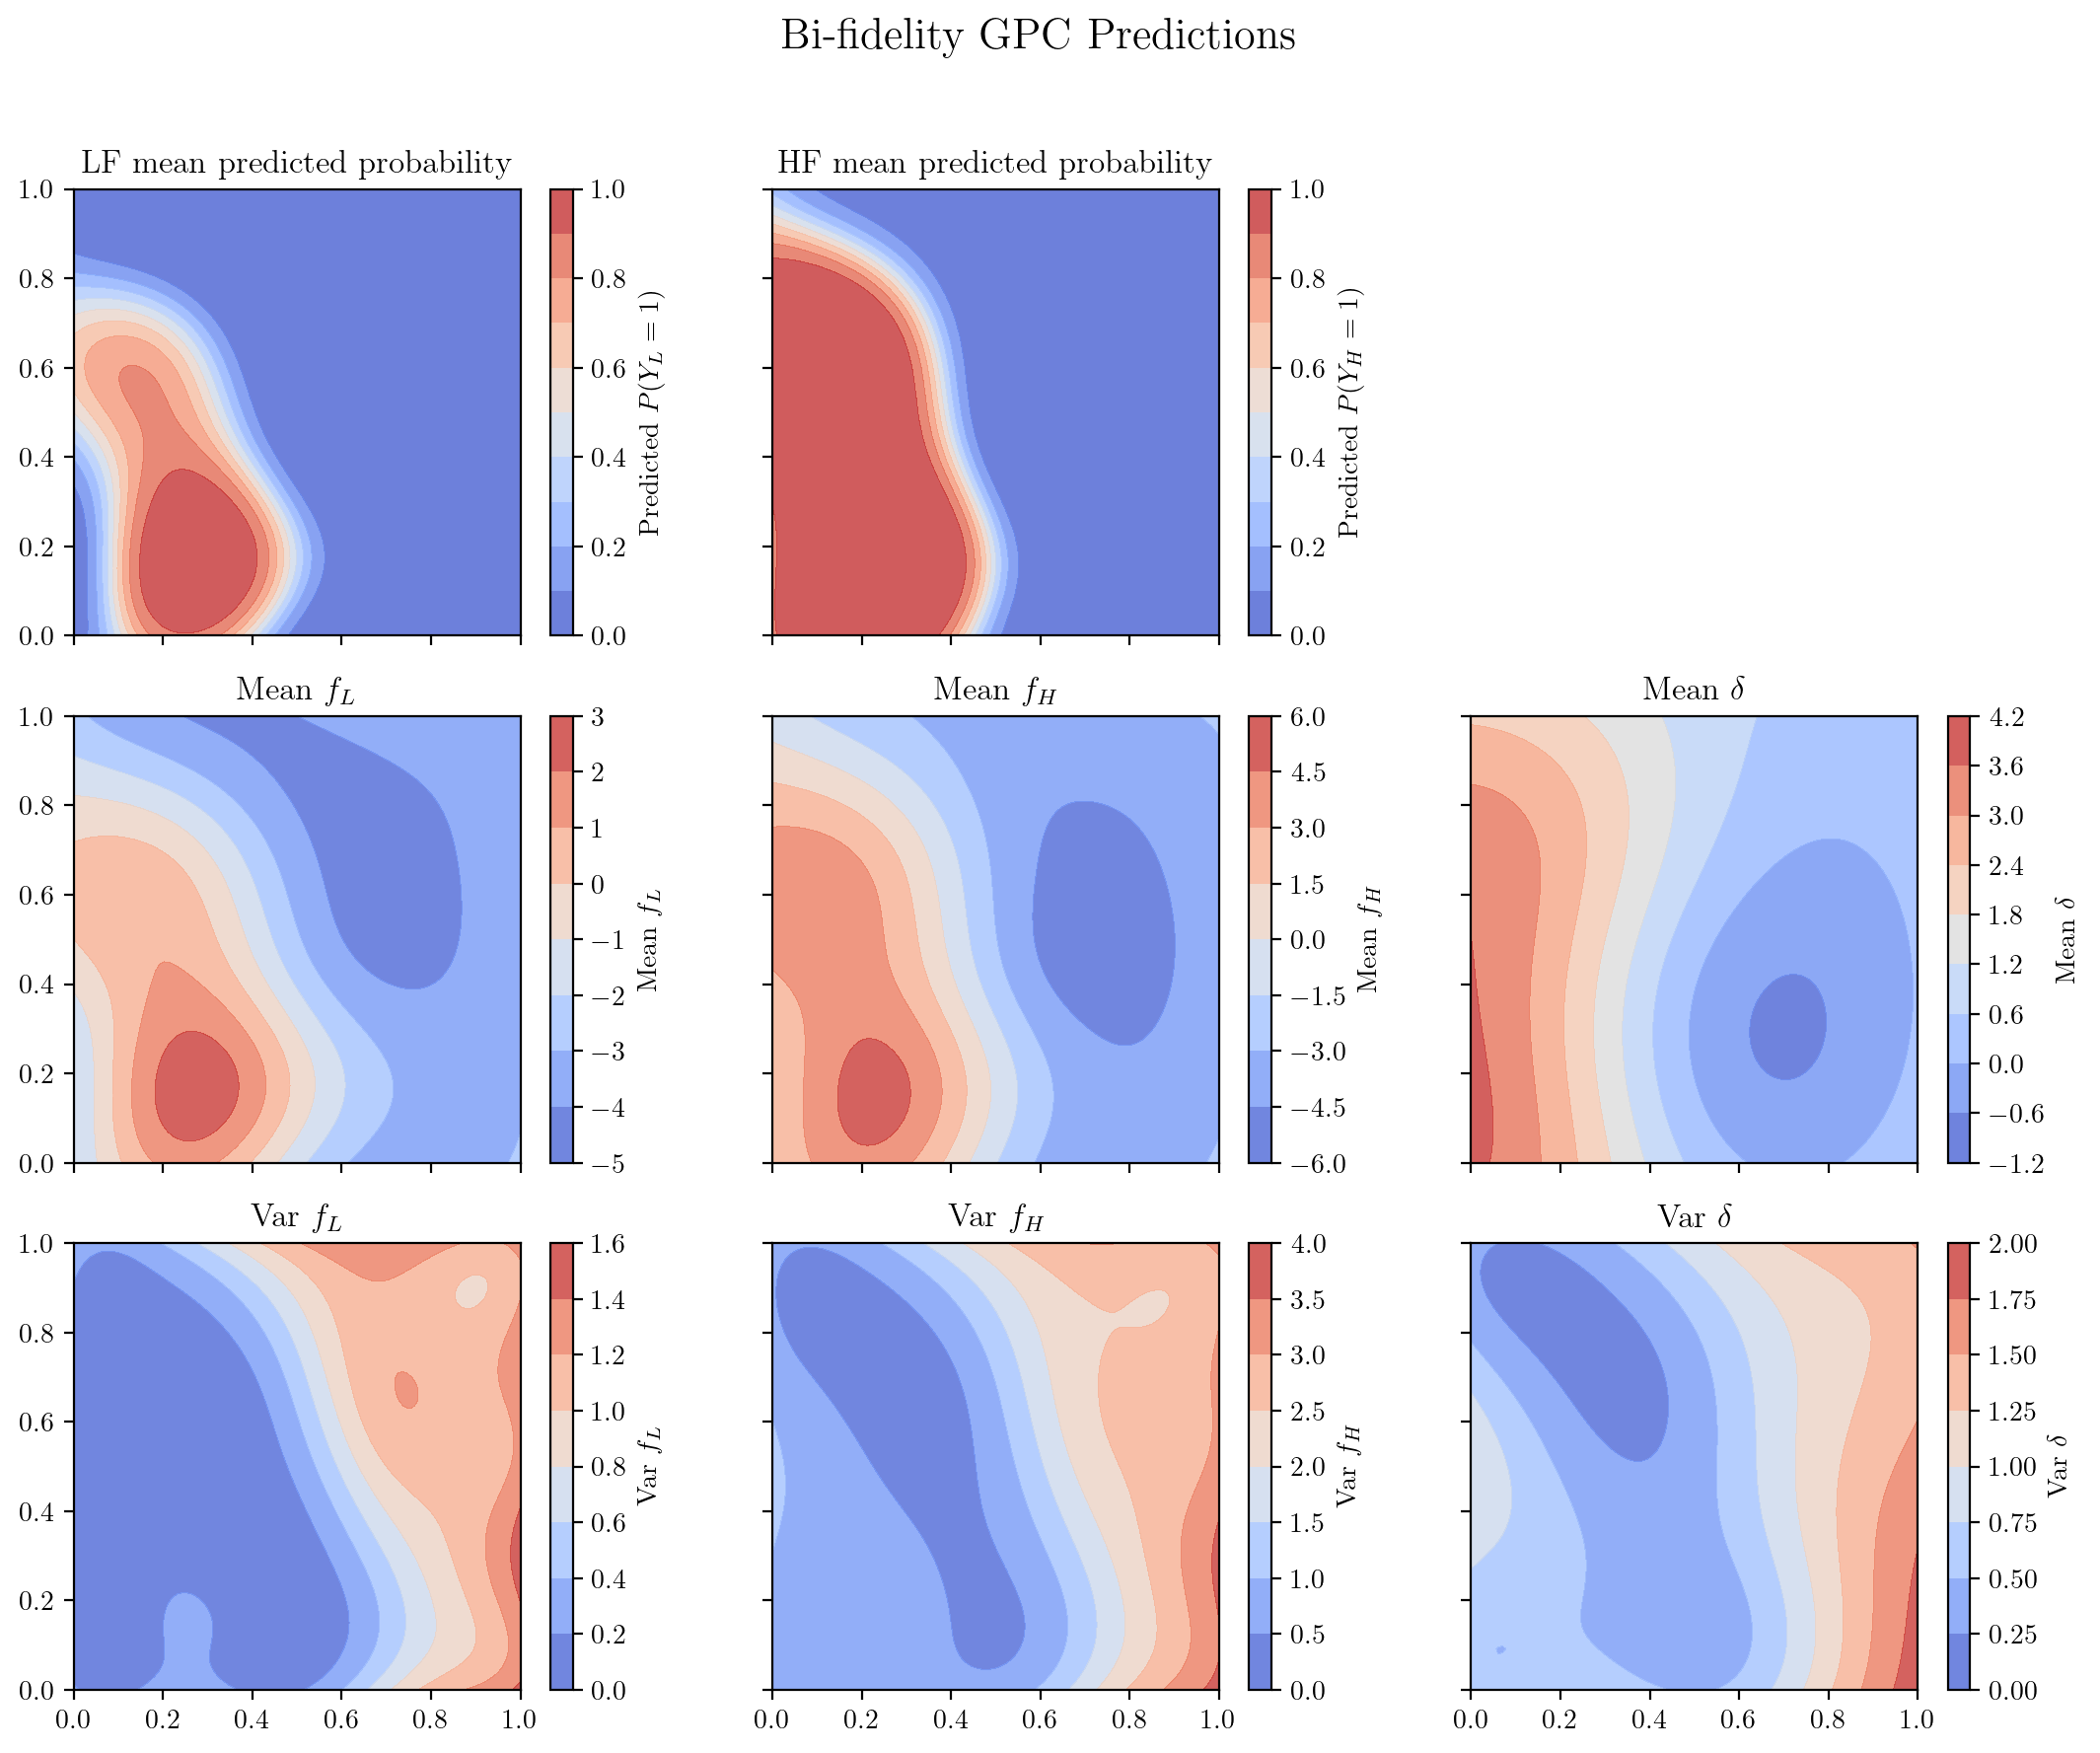

In [8]:
# Train model

model_1 = BFGPC_ELBO(X_lf, X_hf, n_inducing_pts=256)
model_1.train_model(X_lf, Y_lf, X_hf, Y_hf, n_epochs=100, lr=0.1, verbose=True)
plot_bfgpc_predictions_two_axes(model_1)

Selecting batch: 151.29999999999976it [03:29,  1.38s/it]                          

283 123


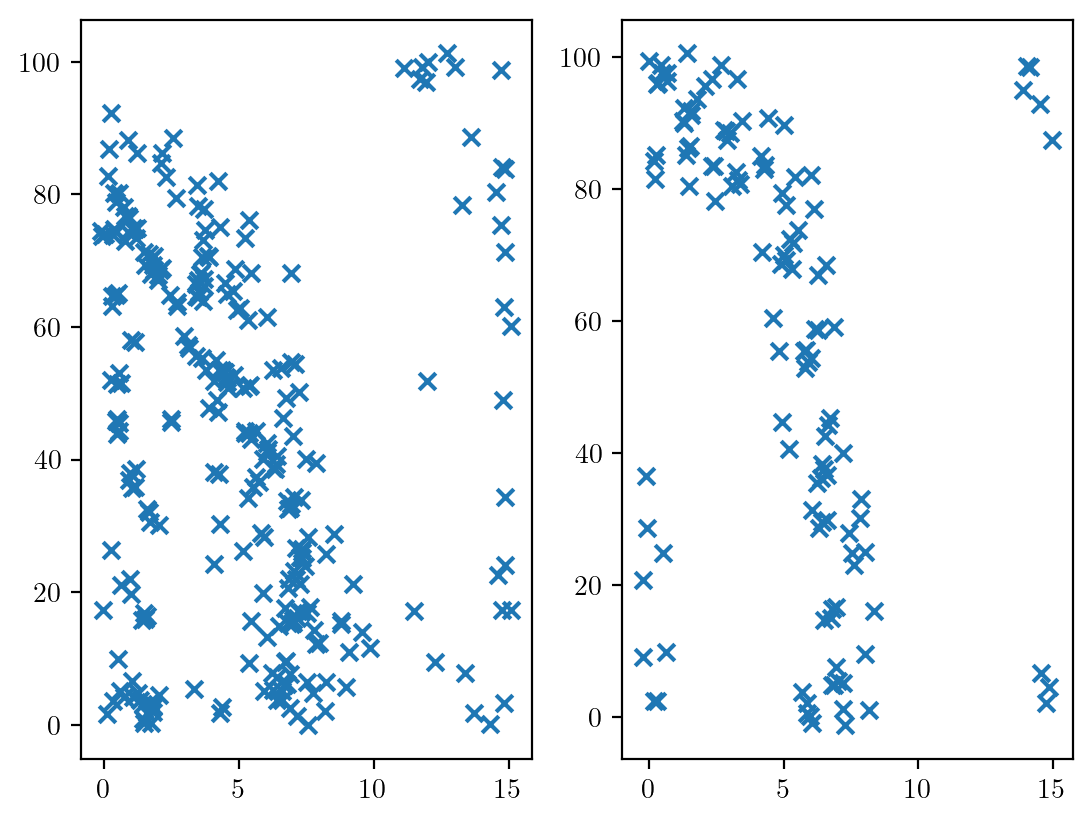

In [11]:
X_lf_new, X_hf_new = strategy.select_batch(config, model_1, budget_this_step=150)
print(len(X_lf_new), len(X_hf_new))

X_lf_new *= np.array([[15, 100]])
X_hf_new *= np.array([[15, 100]])

fig, axs = plt.subplots(1, 2, dpi=200)
axs[0].scatter(X_lf_new[:, 0], X_lf_new[:, 1], marker='x')
axs[1].scatter(X_hf_new[:, 0], X_hf_new[:, 1], marker='x')
plt.show()


In [12]:
torch.save(model_1.state_dict(), 'model_1.pt')
np.save('X_lf_new_2.npy', X_lf_new)
np.save('X_hf_new_2.npy', X_hf_new)

# Round 3

722
176


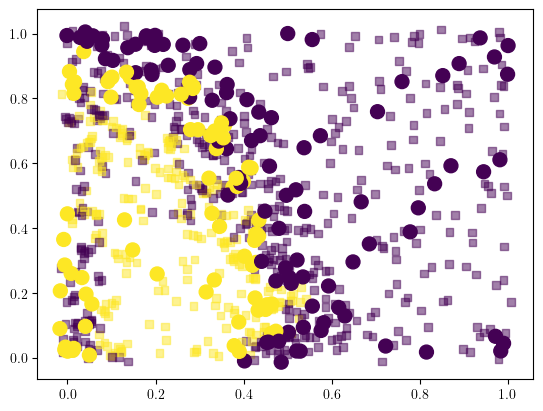

In [12]:
lf_filepaths = ['03_2M.npz', 'AL_01_2M.npz', 'AL_02_2M.npz']
hf_filepaths = ['01_15M.npz', 'AL_01_15M.npz', 'AL_02_15M.npz']

X_lf, Y_lf = load_lf_data(lf_filepaths)
X_hf, Y_hf = load_hf_data(hf_filepaths)

print(len(Y_lf))
print(len(Y_hf))

X_lf = torch.from_numpy(X_lf).float()
X_hf = torch.from_numpy(X_hf).float()
Y_lf = torch.from_numpy(Y_lf).float()
Y_hf = torch.from_numpy(Y_hf).float()

# Plot training data
plt.figure()
plt.scatter(X_lf[:, 0], X_lf[:, 1], c=Y_lf, cmap='viridis', marker='s', s=30, alpha=0.5)
plt.scatter(X_hf[:, 0], X_hf[:, 1], c=Y_hf, cmap='viridis', marker='o', s=100)
plt.show()


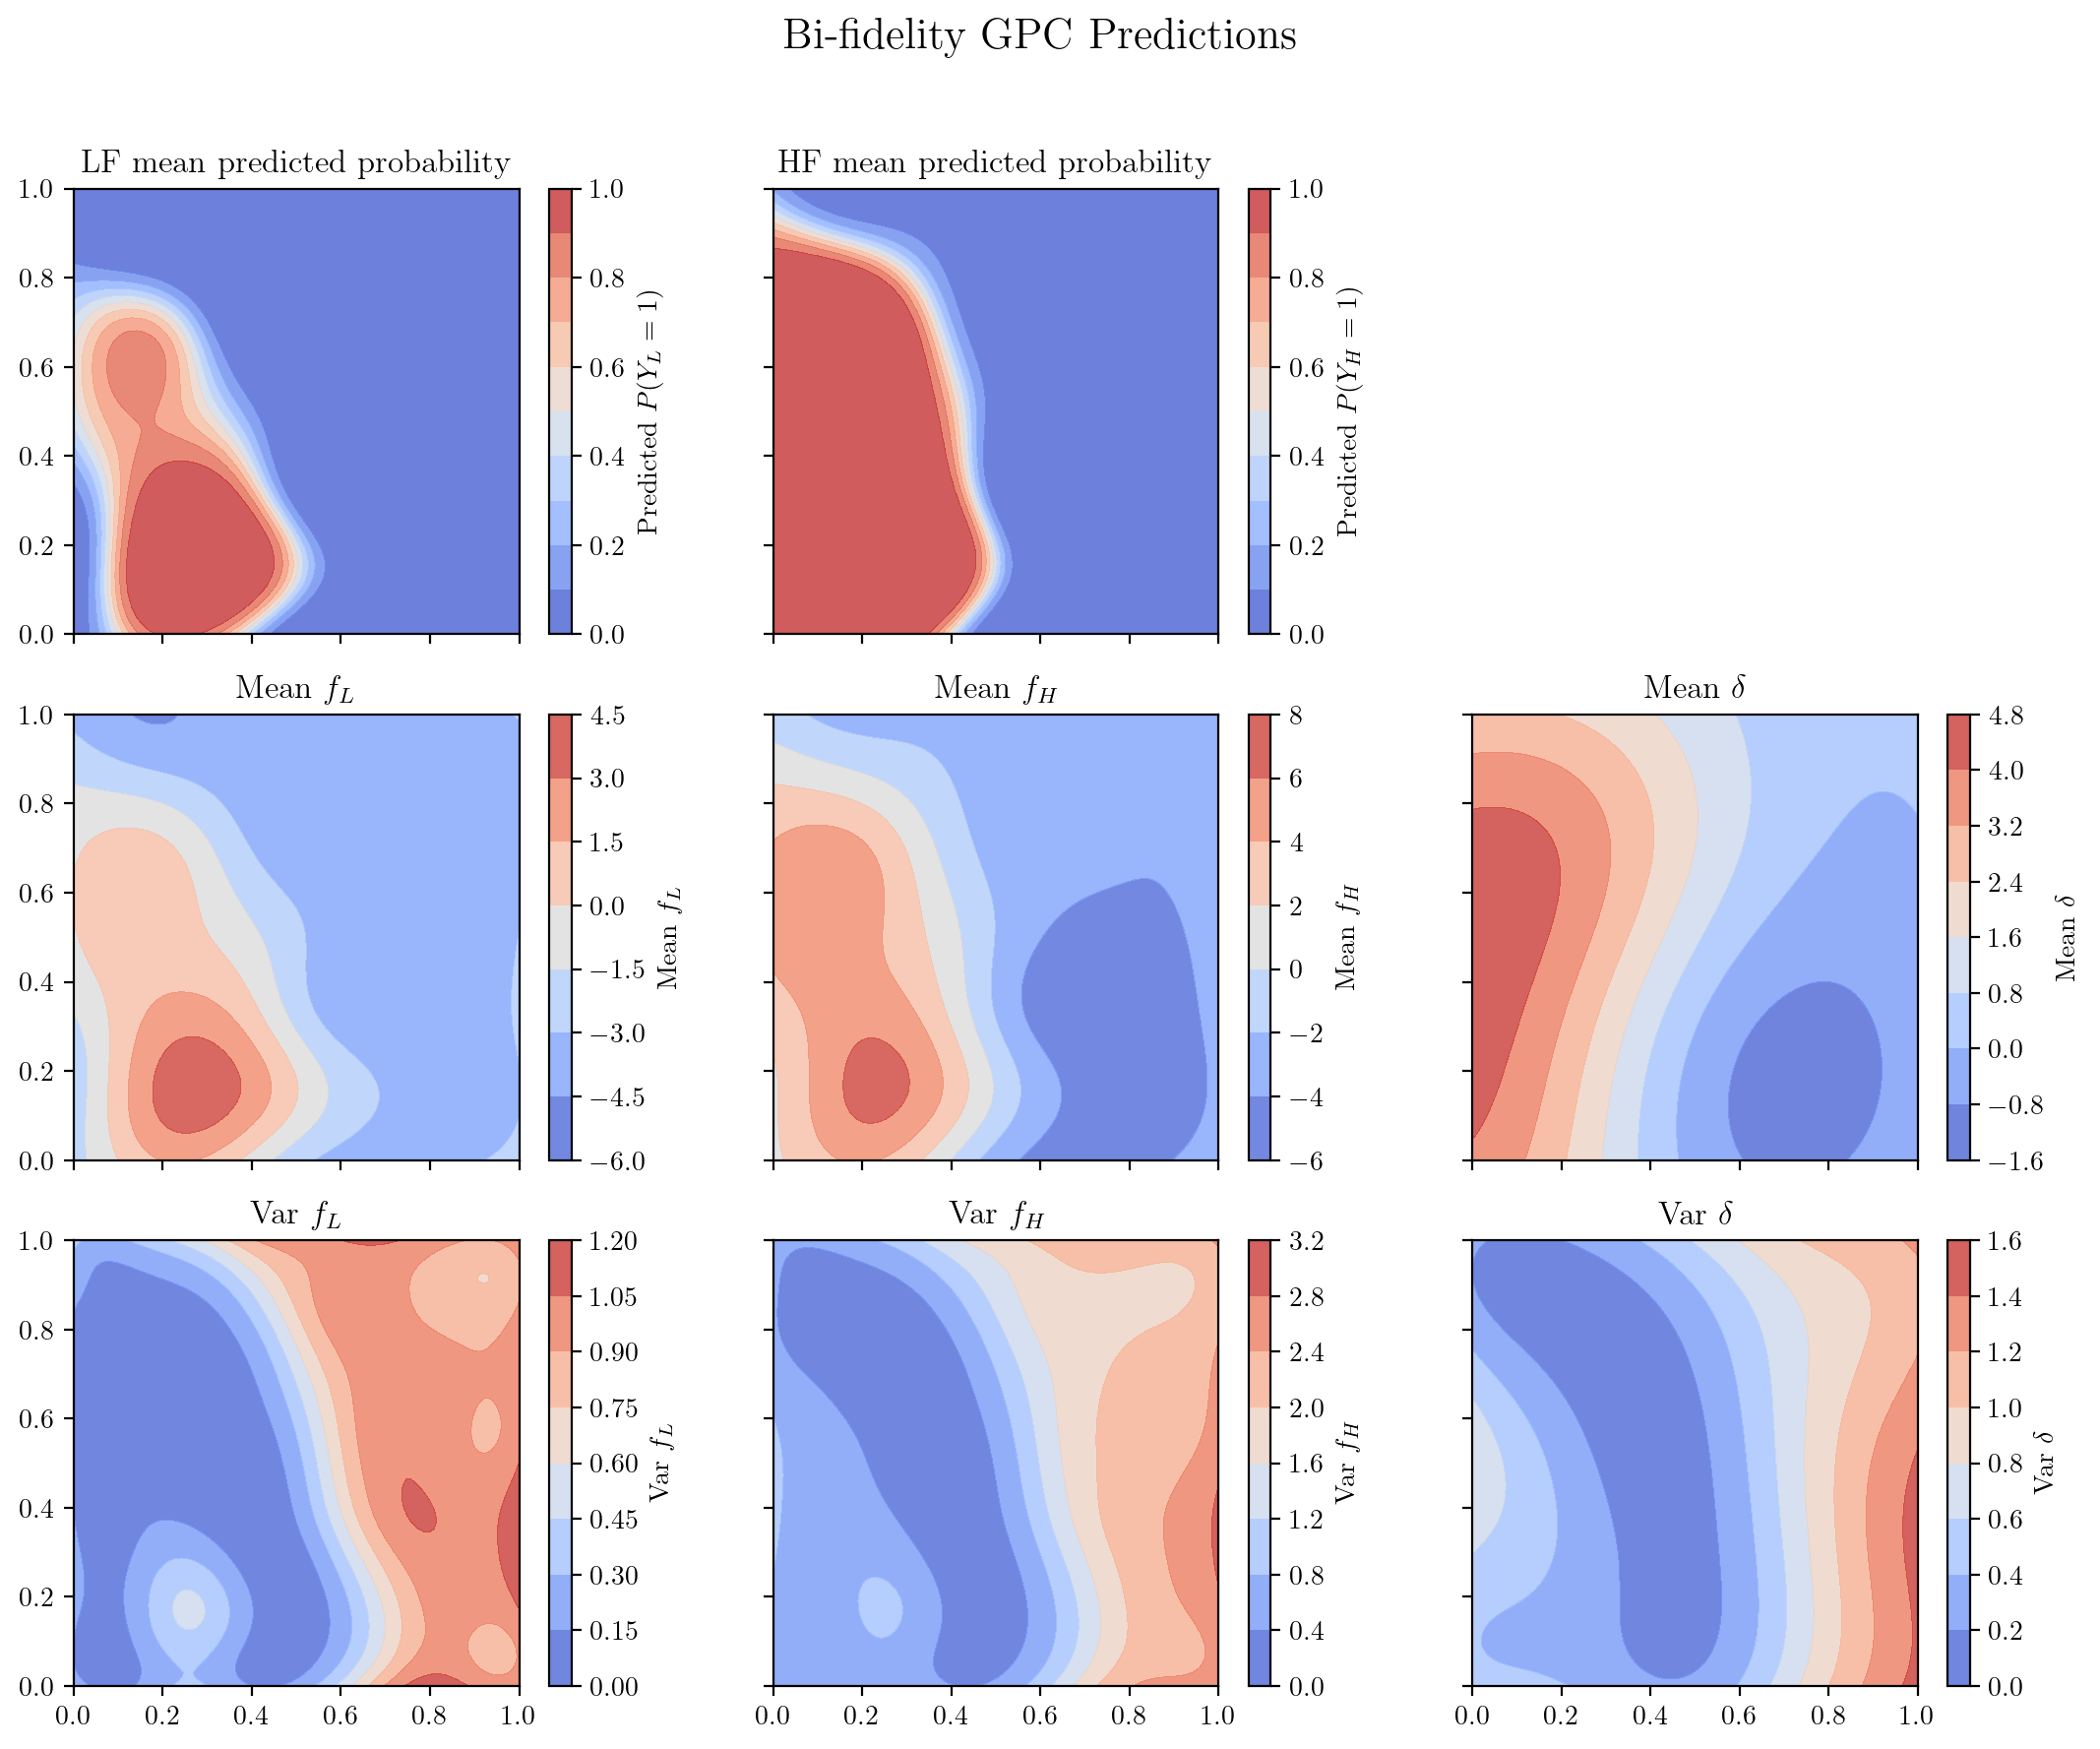

In [6]:
# Train model

model_2 = BFGPC_ELBO(X_lf, X_hf, n_inducing_pts=256)
model_2.train_model(X_lf, Y_lf, X_hf, Y_hf, n_epochs=100, lr=0.1, verbose=True)
plot_bfgpc_predictions_two_axes(model_2)


Selecting batch: 100%|█████████▉| 149.99999999999977/150 [04:51<00:00,  1.94s/it] 

290 121


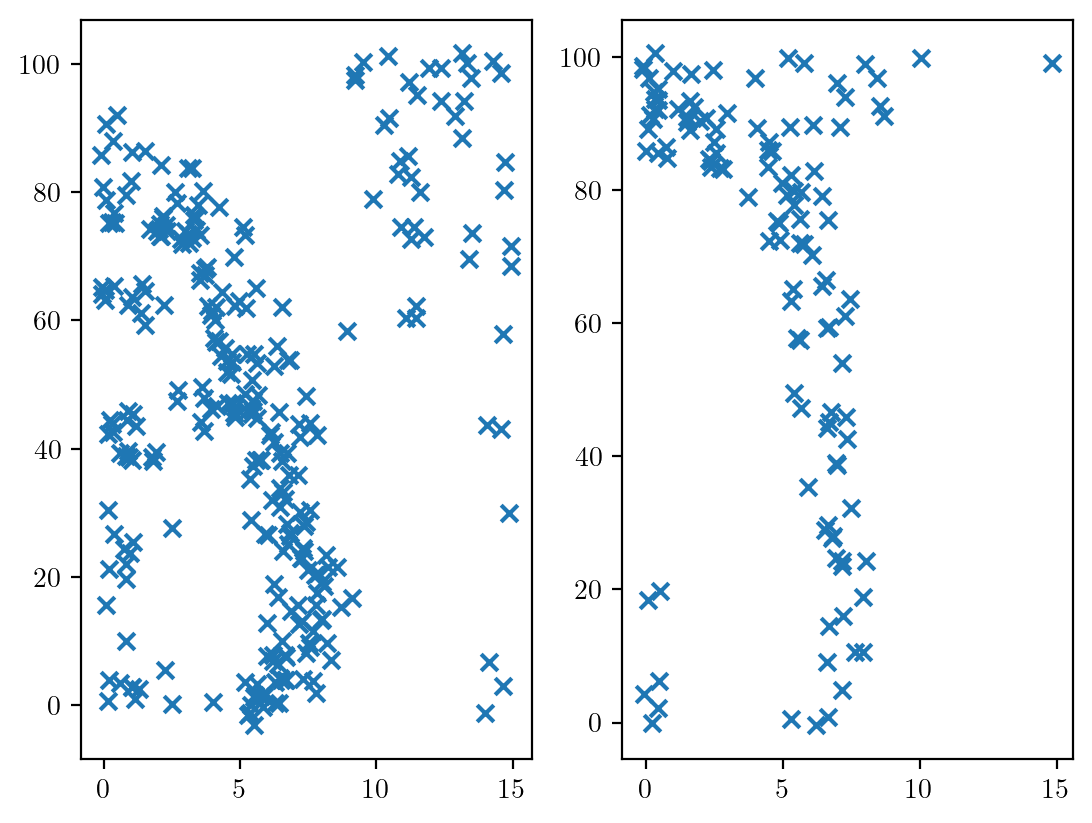

In [10]:
X_lf_new, X_hf_new = strategy.select_batch(config, model_2, budget_this_step=150)
print(len(X_lf_new), len(X_hf_new))

X_lf_new *= np.array([[15, 100]])
X_hf_new *= np.array([[15, 100]])

fig, axs = plt.subplots(1, 2, dpi=200)
axs[0].scatter(X_lf_new[:, 0], X_lf_new[:, 1], marker='x')
axs[1].scatter(X_hf_new[:, 0], X_hf_new[:, 1], marker='x')
plt.show()

In [11]:
torch.save(model_2.state_dict(), 'model_2.pt')
np.save('X_lf_new_3.npy', X_lf_new)
np.save('X_hf_new_3.npy', X_hf_new)
